# Vegetation detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_DATA, TRAIN_LABEL_TILES, get_image_tile_data, normalize, make_ratios_vegetation
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2

### Input data

Images of shape (512, 512, 17) 

In [5]:
from unet import unet_zero

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 4007)


Keras user configuration is setup


In [6]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [7]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [10]:
RESIZE_TILES = False
tile_size = (256, 256)
# channels = np.array(range(11))
channels = np.array([0, 1, 2, 3, 5, 6, 7])
n_channels = len(channels)
# labels = np.array(range(len(LABELS)))
labels = np.array([0, 5, 6, 2])
n_labels = len(labels)

deep=False 
n_filters_0=16

model = unet_zero(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_zero_%i_%i_%s_%i.h5.store" % (n_channels, n_labels, str(deep), n_filters_0))
if os.path.exists(weights_filename):
    print "Found weights file %s" % weights_filename
    model.load_weights(weights_filename)

In [11]:
channels, labels

(array([0, 1, 2, 3, 5, 6, 7]), array([0, 5, 6, 2]))

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 7, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 16, 256, 256)  1024        input_2[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 16, 128, 128)  0           convolution2d_11[0][0]           
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 32, 128, 128)  4640        maxpooling2d_5[0][0]             
___________________________________________________________________________________________

In [13]:
import os
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [14]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_DATA)+1:] for s in all_train_tiles])

In [15]:
all_train_tiles[0]

'6010_1_2_0_0.tif'

In [16]:
from sklearn.model_selection import train_test_split 

# TRAIN ON N TILES
n_tiles = -1
if n_tiles > 0:
    train_tiles, val_tiles = train_test_split(all_train_tiles[:n_tiles], test_size=0.3)
else:
    train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)
    
print len(train_tiles), len(val_tiles)

1120 480


In [17]:
def normalize_image(img_data, max_value=1.0):
    if RESIZE_TILES:
        out = cv2.resize(img_data, dsize=tile_size, interpolation=cv2.INTER_CUBIC).astype(np.float32)
        if len(out.shape) == 2:
            out = out[:, :, None]
    else:
        out = img_data.astype(np.float32)

    if max_value > 1.0:  
        out = normalize(out, 0.01, 99.9)        
    
    out = out.transpose([2,0,1])
    return out


# def make_ratios_vegetation(img_17b):
#     """
#         Method creates an image of all possible band ratios
        
#         - panchromatic[0] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
#         - panchromatic[0] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[1] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[2] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[6] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[6] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[7] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[7] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[7] / MS[10:17] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[8] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
#         - MS[8:17] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
#     """
#     h, w, n = img_17b.shape
    
#     out_n = 23
#     out = np.zeros((h, w, out_n), dtype=np.float32)
#     def _ratio(i, j):
#         return img_17b[:,:,i] / (img_17b[:,:,j] + 0.00001)

#     c = 0
#     out[:,:,c] = _ratio(0, 5); c+= 1
#     out[:,:,c] = _ratio(0, 4); c+= 1
#     out[:,:,c] = _ratio(1, 5); c+= 1
#     out[:,:,c] = _ratio(2, 5); c+= 1
#     out[:,:,c] = _ratio(6, 4); c+= 1
#     out[:,:,c] = _ratio(6, 5); c+= 1
#     out[:,:,c] = _ratio(7, 10); c+= 1
#     out[:,:,c] = _ratio(7, 11); c+= 1
#     out[:,:,c] = _ratio(7, 12); c+= 1
#     out[:,:,c] = _ratio(7, 13); c+= 1
#     out[:,:,c] = _ratio(7, 14); c+= 1
#     out[:,:,c] = _ratio(7, 15); c+= 1
#     out[:,:,c] = _ratio(7, 16); c+= 1
#     out[:,:,c] = _ratio(7, 5); c+= 1
#     out[:,:,c] = _ratio(7, 4); c+= 1
#     out[:,:,c] = _ratio(8, 4); c+= 1
#     out[:,:,c] = _ratio(9, 5); c+= 1
#     out[:,:,c] = _ratio(10, 5); c+= 1
#     out[:,:,c] = _ratio(11, 5); c+= 1
#     out[:,:,c] = _ratio(12, 5); c+= 1
#     out[:,:,c] = _ratio(13, 5); c+= 1
#     out[:,:,c] = _ratio(14, 5); c+= 1
#     out[:,:,c] = _ratio(15, 5); c+= 1
#     return out


def generate_images(train_tiles, batch_size, print_tile_id=False):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                if print_tile_id:
                    print("Tile id: %s" % tile_id)
                x = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))

                x = make_ratios_vegetation(x)
                
                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x, 2.0**10)
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

Tile id: 6110_3_1_1280_2176.tif
Tile id: 6160_2_1_2624_832.tif
Tile id: 6010_1_2_1728_1280.tif
Tile id: 6040_1_0_1728_2624.tif
Tile id: 6010_1_2_0_2176.tif
(5L, 7L, 256L, 256L) (5L, 4L, 256L, 256L)
0.0 1.0 0.0 1.0


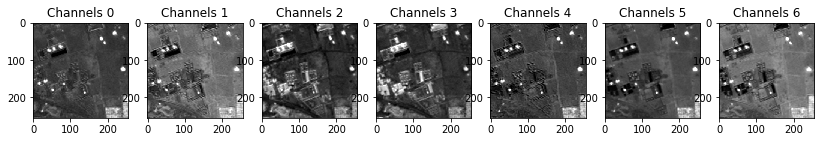

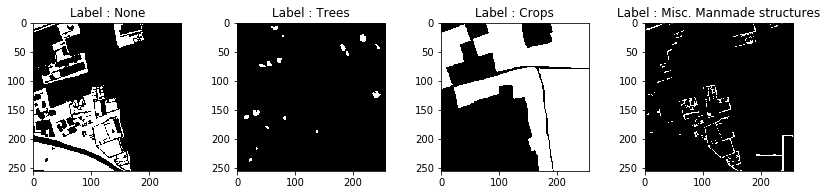

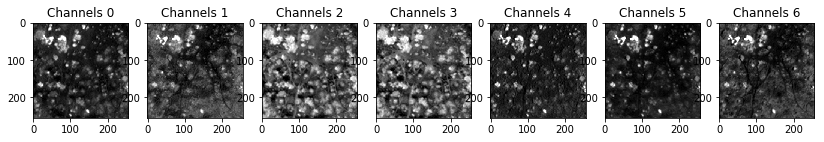

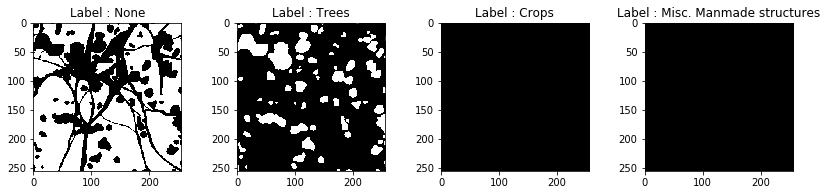

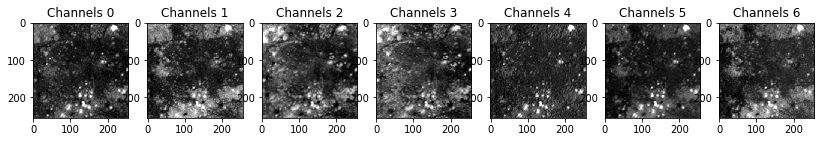

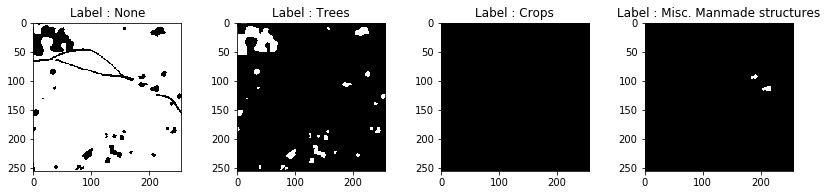

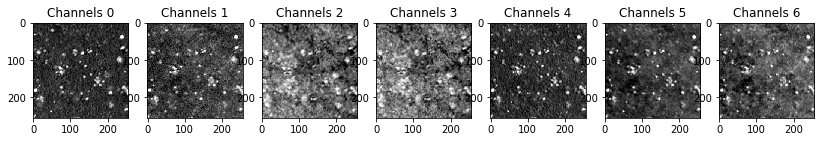

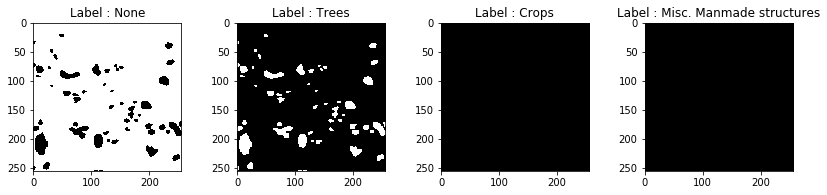

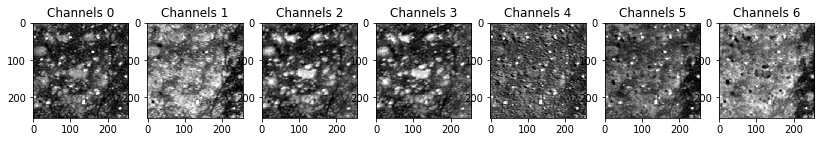

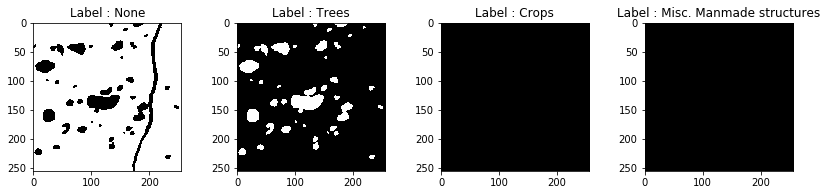

In [18]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))
        for j in range(n_channels):
            plt.subplot(1,n_channels,j+1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
        
        plt.figure(figsize=(14, 6))    
        for j in range(n_labels):
            plt.subplot(2,n_labels,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [19]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
#earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# LearningRateScheduler

In [20]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [21]:
# from keras.callbacks import RemoteMonitor
# rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [22]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=20,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

4 112 48
Epoch 1/20
19s - loss: 333.0165 - jaccard_coef: 2.0827e-05 - jaccard_coef_int: 2.2779e-14 - acc: 0.0594 - val_loss: 332.2167 - val_jaccard_coef: 2.6113e-05 - val_jaccard_coef_int: 2.6226e-14 - val_acc: 0.0078
Epoch 2/20
15s - loss: 320.7996 - jaccard_coef: 2.9712e-05 - jaccard_coef_int: 1.4127e-14 - acc: 0.0260 - val_loss: 336.2882 - val_jaccard_coef: 2.7809e-05 - val_jaccard_coef_int: 1.7699e-14 - val_acc: 0.0034
Epoch 3/20
14s - loss: 333.9817 - jaccard_coef: 2.7993e-05 - jaccard_coef_int: 2.1027e-14 - acc: 0.0390 - val_loss: 340.0242 - val_jaccard_coef: 3.2604e-05 - val_jaccard_coef_int: 2.6370e-14 - val_acc: 0.0467
Epoch 4/20
15s - loss: 330.1703 - jaccard_coef: 2.8414e-05 - jaccard_coef_int: 2.4858e-14 - acc: 0.0148 - val_loss: 330.1189 - val_jaccard_coef: 2.8432e-05 - val_jaccard_coef_int: 1.4115e-14 - val_acc: 0.0099
Epoch 5/20
15s - loss: 328.4631 - jaccard_coef: 3.1546e-05 - jaccard_coef_int: 1.1520e-14 - acc: 0.0103 - val_loss: 333.0260 - val_jaccard_coef: 3.3544e-05

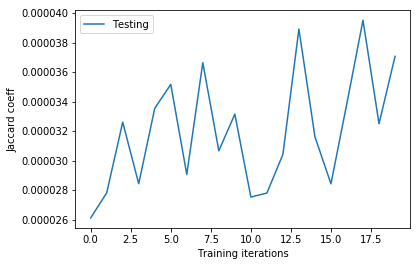

In [23]:
# plt.plot(history.history['val_jaccard_coef_int'])
# plt.ylabel('Jaccard coeff integer')
plt.plot(history.history['val_jaccard_coef'])
plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [37]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5L, 4L, 256L, 256L) 2.74472e-07 0.00101414


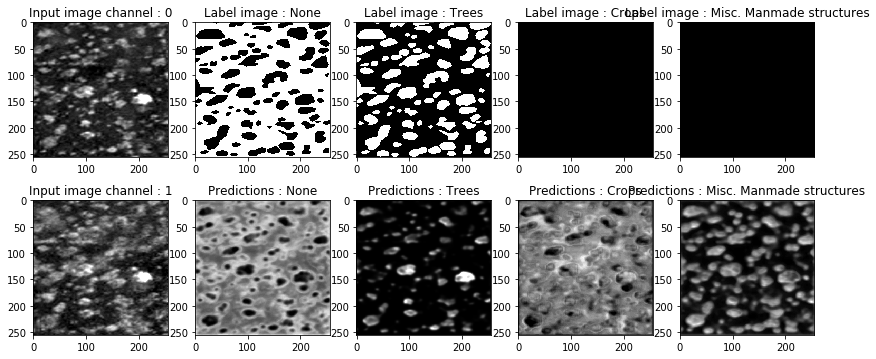

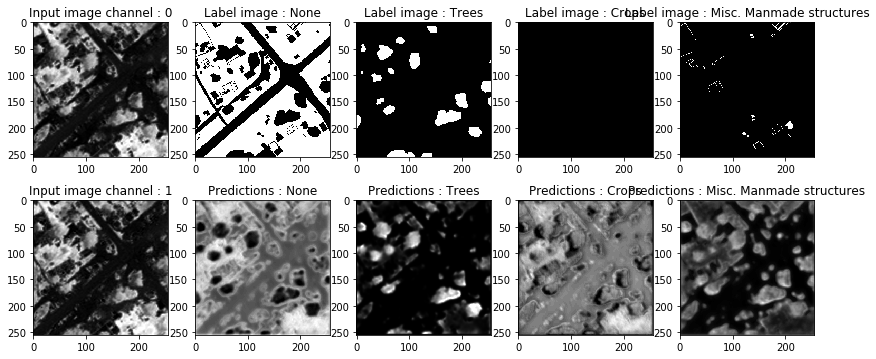

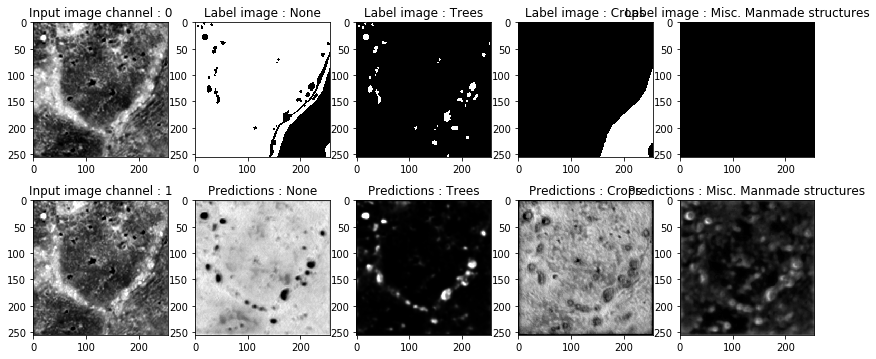

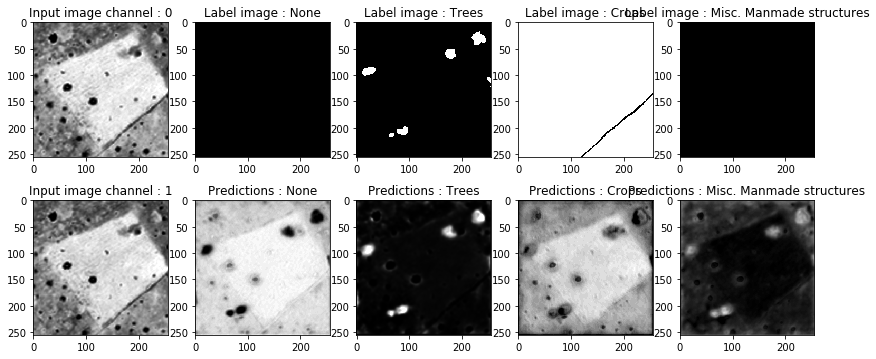

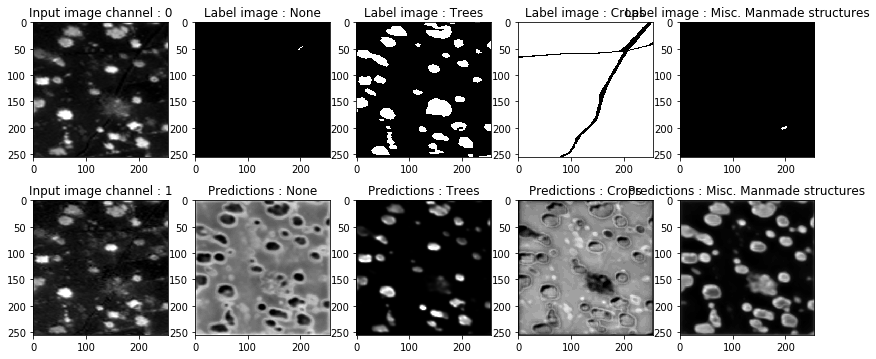

In [24]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


(5, 4, 256, 256) 3.76119e-08 0.0021728


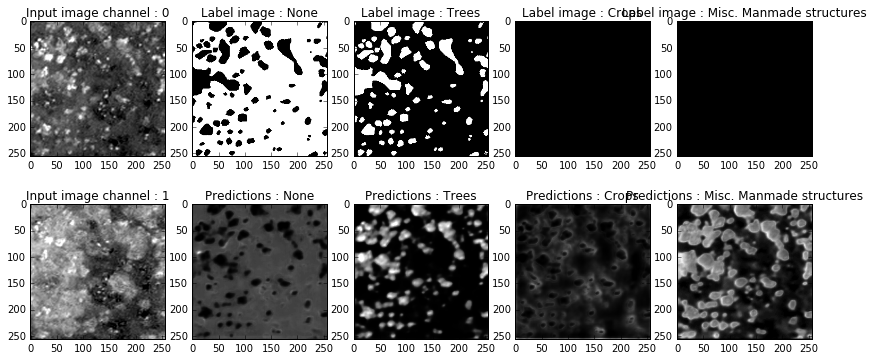

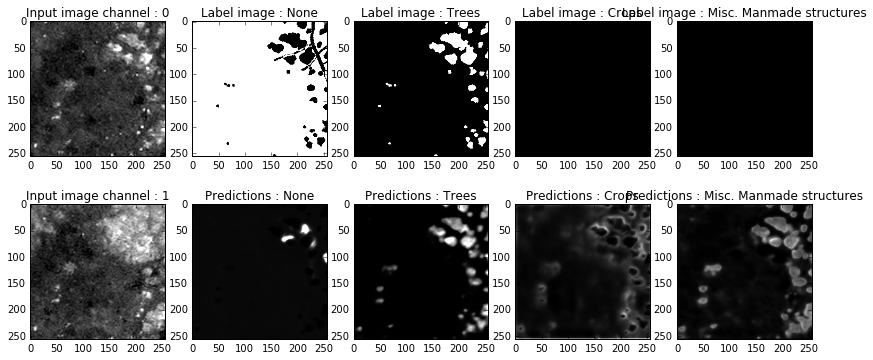

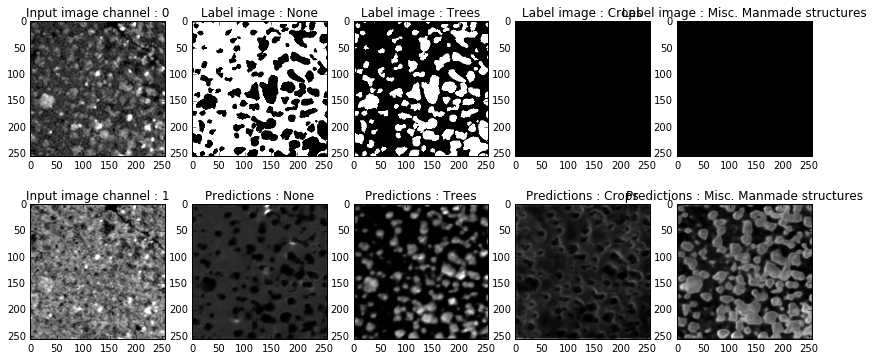

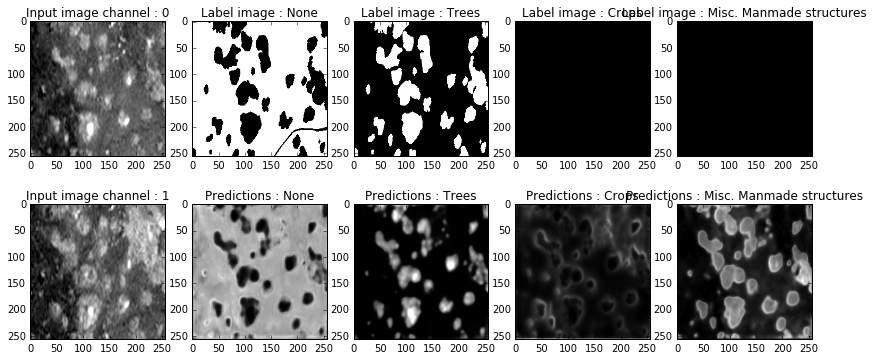

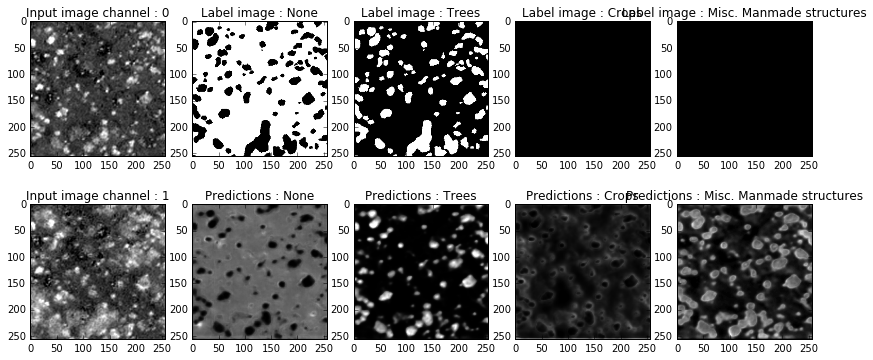

In [54]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


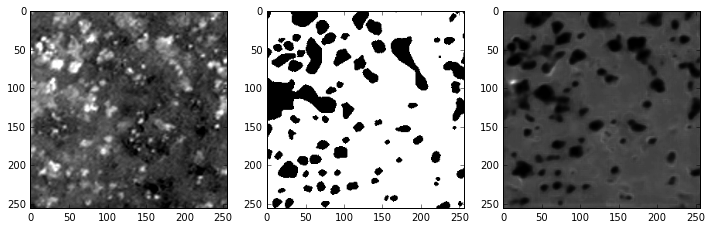

In [55]:
_plot(X, Y, Y_pred, 0, 0)

In [46]:
y = Y_pred[0,2,:,:]
print y.min(), y.max()

2.69546e-07 0.000206497
